In [ ]:
import pandas as pd
import yfinance as yf


def get_data(tickers, start_date, end_date):
    df = pd.DataFrame()
    for ticker in tickers:
        print(f"Downloading data for {ticker}...")
        stock = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
        stock.name = ticker
        if df.empty:
            df = pd.DataFrame(stock)
        else:
            df[ticker] = stock
    return df

start_date = '2023-12-05'
end_date = '2024-12-06'

# get 4 tech, walmart, and SP500
stocks = ['ARM', 'INTC', 'NVDA', 'PLTR', 'WMT', '^GSPC']
data = get_data(stocks, start_date, end_date)

# print(data)

rf_data = yf.download('^IRX', start=start_date, end=end_date)['Adj Close']
daily_rf = ((1 + rf_data / 100) ** (1 / 252) - 1)

# print(rf_data)
# print(daily_rf)

returns = data.pct_change().dropna()

# Calculate excess returns
daily_rf_series = daily_rf['^IRX']
excess_returns = returns.subtract(daily_rf_series, axis=0)
print(excess_returns.describe())

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


Ticker         ARM        INTC        NVDA        PLTR         WMT       ^GSPC
count   252.000000  252.000000  252.000000  252.000000  252.000000  252.000000
mean      0.004326   -0.002369    0.004857    0.005994    0.002331    0.000968
std       0.055805    0.032259    0.032820    0.039905    0.010873    0.007710
min      -0.194805   -0.260780   -0.100249   -0.151333   -0.024513   -0.030165
25%      -0.021085   -0.016834   -0.014255   -0.015415   -0.003676   -0.002988
50%       0.003942    0.000075    0.004883    0.001537    0.001831    0.001067
75%       0.026557    0.014959    0.024078    0.020148    0.008496    0.005451
max       0.478697    0.094691    0.163806    0.307812    0.069662    0.025124


In [ ]:
import numpy as np

# C = covariance of risky stocks
# m = vector of expected (excess) returns
# w = weight vector

# print(excess_returns.columns)

stock_returns = pd.DataFrame(excess_returns.drop(columns=["^GSPC"]))

mu = stock_returns.mean()
C = stock_returns.cov()


ones = np.ones(len(stocks) - 1)
inv_cov = np.linalg.inv(C)

# weight vector for the MVP
w_mvp = np.dot(inv_cov, ones) / np.dot(ones.T, np.dot(inv_cov, ones))

# weight vector for the MP
w_mp = np.dot(inv_cov, mu) / np.dot(ones.T, np.dot(inv_cov, mu))


def portfolio_metrics(w, mu, C):

    expected_return = np.dot(mu, w)
    sigma = np.sqrt(np.dot(w.T, np.dot(C, w)))

    return expected_return, sigma

# MVP metrics
mvp_return, mvp_std = portfolio_metrics(w_mvp, mu, C)

# MP metrics
mp_return, mp_std = portfolio_metrics(w_mp, mu, C)

# exclude S&P itself
# q = excess_returns.cov()['^GSPC'].iloc[:-1]
# q = excess_returns.cov().loc["^GSPC"]
q = stock_returns.apply(lambda x: x.cov(excess_returns["^GSPC"]))

mvp_sp500_cov = np.dot(w_mvp, q)
mp_sp500_cov = np.dot(w_mp, q)

print("MVP Return:", mvp_return)
print("MVP Risk:", mvp_std)
print("MP Return:", mp_return)
print("MP Risk:", mp_std)
print("Covariance of MVP with S&P 500:", mvp_sp500_cov)
print("Covariance of MP with S&P 500:", mp_sp500_cov)

print("\nMP Weights:")
print(pd.Series(w_mvp, index=mu.index))

print("\nMVP Weights:")
print(pd.Series(w_mp, index=mu.index))

print(f"\nMVP Point: ({mvp_return}, {mvp_std})")
print(f"\nMP Point: ({mp_return}, {mp_std})")

# It looks like there is short selling for both MVP and MP weights
# as there are negative values (ARM for MP and INTC for MVP)

MVP Return: 0.002420374035900751
MVP Risk: 0.010231740846087708
MP Return: 0.004551149007714117
MP Risk: 0.014030360055425486
Covariance of MVP with S&P 500: 3.399319495198506e-05
Covariance of MP with S&P 500: 3.775881444266527e-05

MP Weights:
Ticker
ARM    -0.000357
INTC    0.036373
NVDA    0.082289
PLTR    0.014592
WMT     0.867103
dtype: float64

MVP Weights:
Ticker
ARM     0.013618
INTC   -0.247457
NVDA    0.217084
PLTR    0.131550
WMT     0.885204
dtype: float64

MVP Point: (0.002420374035900751, 0.010231740846087708)

MP Point: (0.004551149007714117, 0.014030360055425486)


In [ ]:
def sharpe_ratio(returns, risk_free_rate=0):
    return_mean = returns.mean()
    return_std = returns.std()
    return (return_mean - risk_free_rate) / return_std

sharpe_ratios = {stock: sharpe_ratio(stock_returns[stock]) for stock in stock_returns.columns}
sharpe_ratios["S&P 500"] = sharpe_ratio(excess_returns["^GSPC"])
sharpe_ratios["MVP"] = sharpe_ratio(stock_returns @ w_mvp)

sp500_variance = excess_returns['^GSPC'].var()
betas = q / sp500_variance  # q = cov w/ SP500

mvp_sp500_cov = np.dot(w_mvp, q)
mp_sp500_cov = np.dot(w_mp, q)

mvp_beta = mvp_sp500_cov / sp500_variance
mp_beta = mp_sp500_cov / sp500_variance


# Create results DataFrame
results = pd.DataFrame({
    "Sharpe Ratio": sharpe_ratios,
    "Cov w/ S&P 500": q,
    "Beta": betas
})

# add MVP and MP data to results
results.loc["MVP"] = {
    "Sharpe Ratio": sharpe_ratios["MVP"],
    "Cov w/ S&P 500": mvp_sp500_cov,
    "Beta": mvp_beta
}
results.loc["MP"] = {
    "Sharpe Ratio": sharpe_ratios.get("MP", np.nan),  # Ensure MP exists or use NaN
    "Cov w/ S&P 500": mp_sp500_cov,
    "Beta": mp_beta
}

correlation_summary = {
    item: "Positive" if value > 0 else "Negative" for item, value in q.items()
}
print(f"{results}\n")
for item, correlation in correlation_summary.items():
    print(f"{item}: {correlation} correlation with S&P 500")


         Sharpe Ratio  Cov w/ S&P 500      Beta
ARM          0.077527        0.000200  3.366364
INTC        -0.073436        0.000132  2.214411
MVP          0.236555        0.000034  0.571801
NVDA         0.147991        0.000165  2.778857
PLTR         0.150205        0.000135  2.269342
S&P 500      0.125549             NaN       NaN
WMT          0.214347        0.000016  0.266030
MP                NaN        0.000038  0.635142

ARM: Positive correlation with S&P 500
INTC: Positive correlation with S&P 500
NVDA: Positive correlation with S&P 500
PLTR: Positive correlation with S&P 500
WMT: Positive correlation with S&P 500


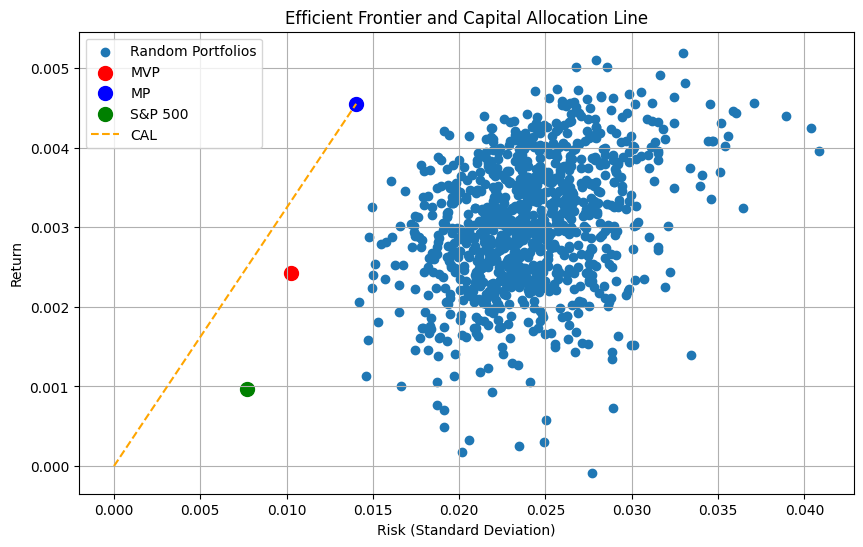


Median of expected returns: 0.003036053802262825

best portfolio point: (0.014941291968133246, 0.003253667042246134)

best portfolio weights:
ARM: 0.11085198868315899
INTC: 0.04176593690492206
NVDA: 0.07980627741976158
PLTR: 0.19011336193112938
WMT: 0.577462435061028


In [ ]:
import matplotlib.pyplot as plt


N = 1000
M = 5

# generate random weights
random_weights = np.random.uniform(0, 1, (N, M))
random_weights = random_weights / random_weights.sum(axis=1, keepdims=True)
weights_df = pd.DataFrame(random_weights, columns=[f"stock_{i+1}" for i in range(M)])


# Compute (return, risk) points for random weight vectors
random_points = np.array([portfolio_metrics(weights, mu, C) for weights in random_weights])
random_returns = random_points[:, 0]
random_risks = random_points[:, 1]

# Add points for MVP, MP, and S&P 500
sp_return = excess_returns["^GSPC"].mean()
sp_risk = excess_returns["^GSPC"].std()

plt.figure(figsize=(10, 6))
plt.scatter(random_risks, random_returns, label='Random Portfolios')
plt.scatter(mvp_std, mvp_return, color="red", label="MVP", marker="o", s=100)
plt.scatter(mp_std, mp_return, color="blue", label="MP", marker="o", s=100)
plt.scatter(sp_risk, sp_return, color="green", label="S&P 500", marker="o", s=100)

# capital allocation line
plt.plot([0, mp_std], [0, mp_return], color="orange", linestyle="--", label="CAL")
plt.title("Efficient Frontier and Capital Allocation Line")
plt.xlabel("Risk (Standard Deviation)")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()


median_return = np.median(random_returns)
print(f"\nMedian of expected returns: {median_return}")

valid_portfolios = random_returns >= median_return

# best portfolio where risk is minimized
min_risk_idx = random_risks[valid_portfolios].argmin()
best_portfolio = random_weights[valid_portfolios][min_risk_idx]

print(f"\nbest portfolio point: ({random_risks[valid_portfolios][min_risk_idx]}, {random_returns[valid_portfolios][min_risk_idx]})\n")

print("best portfolio weights:")
for stock, weight in zip(stocks, best_portfolio):
    print(f"{stock}: {weight}")

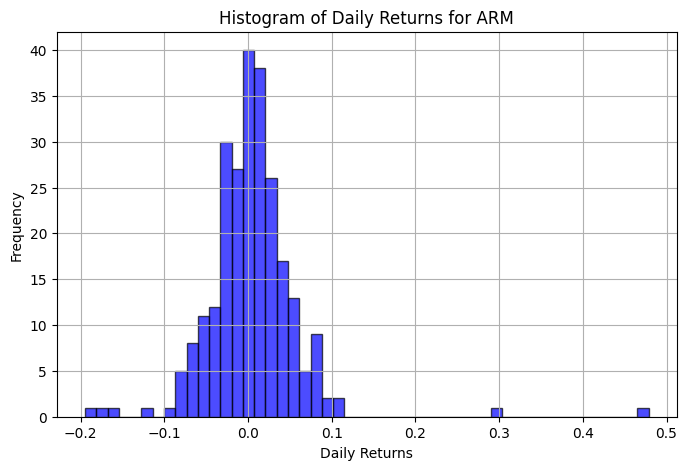

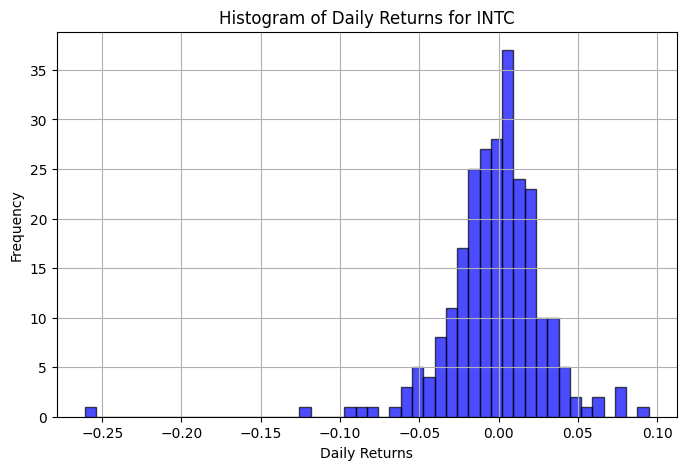

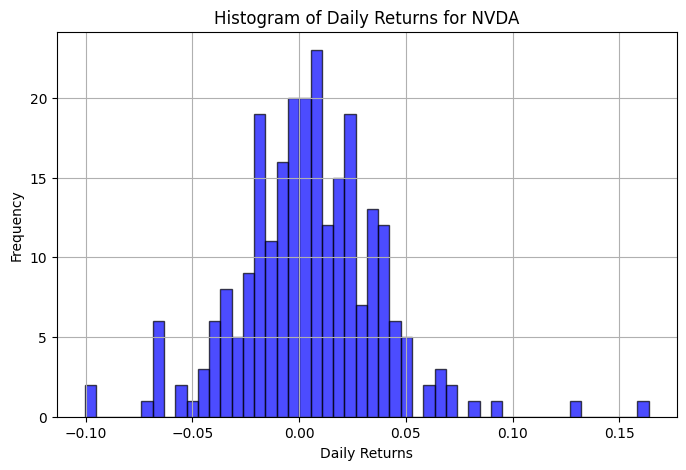

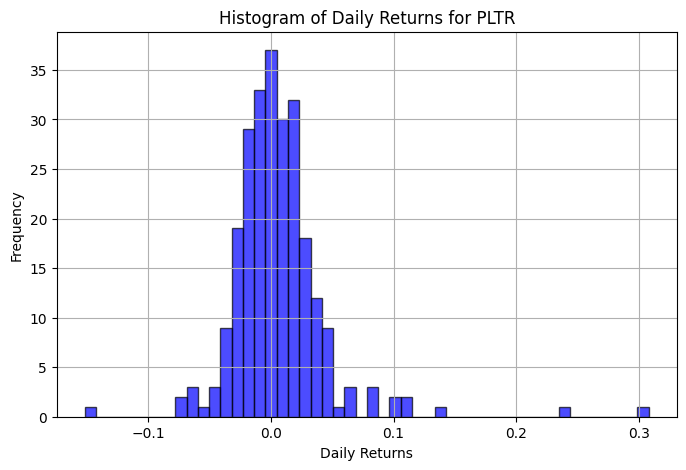

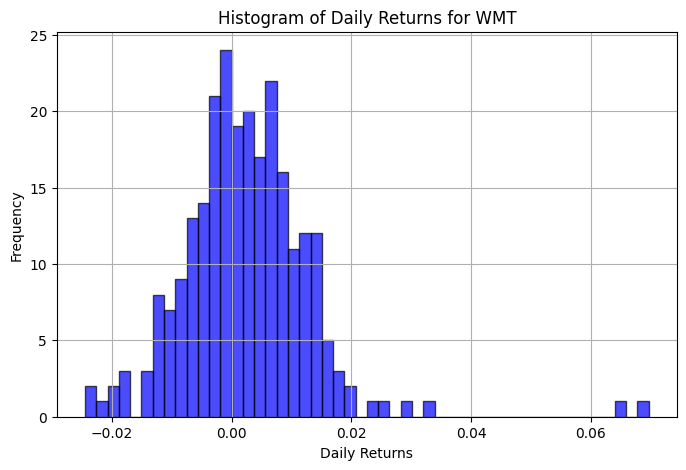

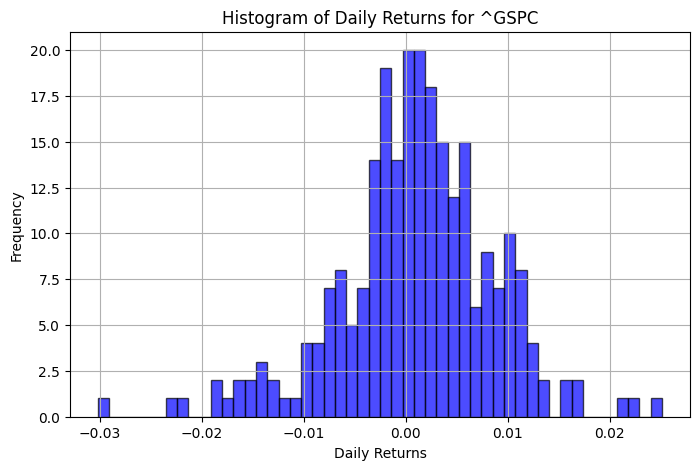

         VaR_5%   CVaR_5%   VaR_10%  CVaR_10%
ARM    0.077911 -0.002402  0.055019 -0.006274
INTC   0.041826 -0.005541  0.029966 -0.007795
NVDA   0.051353  0.001027  0.040894 -0.001504
PLTR   0.065651  0.000094  0.040355 -0.002586
WMT    0.016763  0.000963  0.013708  0.000163
^GSPC  0.012112  0.000191  0.010157 -0.000433


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Part A
# histograms for returns

for stock in stocks:
    plt.figure(figsize=(8, 5))
    plt.hist(excess_returns[stock], bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Histogram of Daily Returns for {stock}")
    plt.xlabel("Daily Returns")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


# Part B
# Compute VaR and CVaR for alpha = 5% and 10%

def var_cvar(returns, alpha):

    sorted_returns = np.sort(returns)
    var_index = int((1 - alpha) * len(sorted_returns))
    var = sorted_returns[var_index]
    cvar = sorted_returns[:var_index].mean()  # Average of returns below the VaR

    return var, cvar


alphas = [0.05, 0.10]
var_cvar_results = {}


for stock in stocks:
    if stock in excess_returns.columns:
        stock_results = {}

        for a in alphas:
            var, cvar = var_cvar(excess_returns[stock], a)
            stock_results[f"VaR_{int(a*100)}%"] = var
            stock_results[f"CVaR_{int(a*100)}%"] = cvar

        var_cvar_results[stock] = stock_results

# make results a dataframe so it looks nicer
var_cvar_df = pd.DataFrame(var_cvar_results).T
print(var_cvar_df)

In [ ]:
# Part A

# reuse var_cvar from the previous code block

def daily_returns(returns, w):
    return returns @ w

# Part B
alphas = [0.05, 0.10]

mvp_daily_returns = daily_returns(excess_returns.drop(columns=["^GSPC"]), w_mvp)
mp_daily_returns = daily_returns(excess_returns.drop(columns=["^GSPC"]), w_mp)
sp500_daily_returns = excess_returns["^GSPC"].values

print("### MVP, MP, S&P 500 VaR and CVaR ###")
for a in alphas:
    var_mvp, cvar_mvp = var_cvar(mvp_daily_returns, a)
    var_mp, cvar_mp = var_cvar(mp_daily_returns, a)
    var_sp, cvar_sp = var_cvar(sp500_daily_returns, a)

    print(f"\nAlpha = {int(a*100)}%:")
    print(f"MVP VaR: {var_mvp}, MVP CVaR: {cvar_mvp}")
    print(f"MP VaR: {var_mp}, MP CVaR: {cvar_mp}")
    print(f"S&P 500 VaR: {var_sp}, S&P 500 CVaR: {cvar_sp}")

### MVP, MP, S&P 500 VaR and CVaR ###

Alpha = 5%:
MVP VaR: 0.016963852155148854, MVP CVaR: 0.0011628176351249691
MP VaR: 0.029255866856590533, MP CVaR: 0.0026768169502976707
S&P 500 VaR: 0.01211239483793669, S&P 500 CVaR: 0.00019145503678533876

Alpha = 10%:
MVP VaR: 0.012820956901482371, MVP CVaR: 0.0003894938502152848
MP VaR: 0.021106371521035762, MP CVaR: 0.00151010226189045
S&P 500 VaR: 0.010157432506229025, S&P 500 CVaR: -0.00043277493581000455


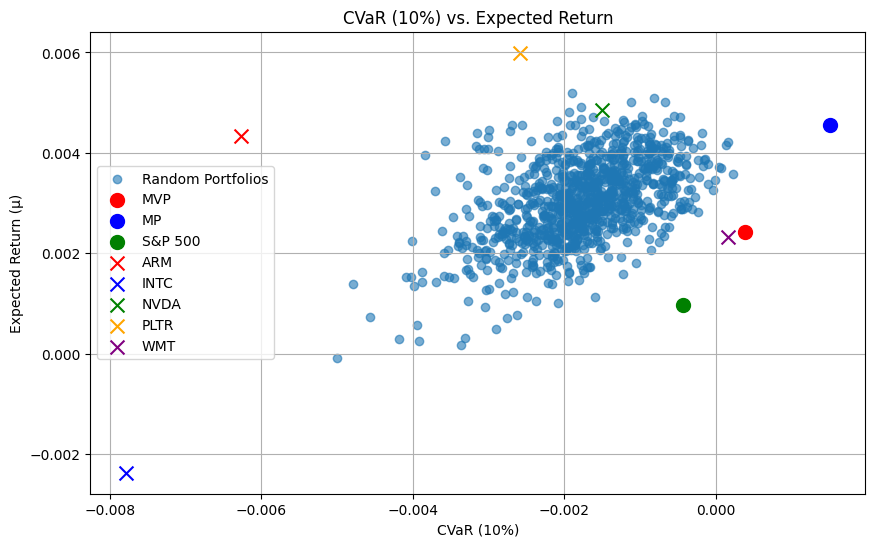

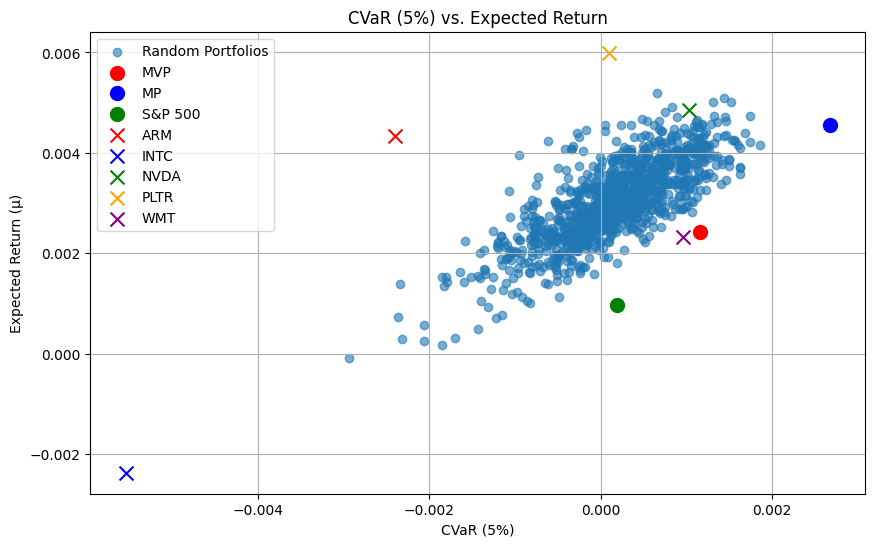

In [ ]:
# Part C
# Compute CVaR for the same 100 random weight vectors at alpha=10% and alpha=5%

cvar_10_random = []
cvar_5_random = []

for w in random_weights:
    p_daily = daily_returns(excess_returns.drop(columns=["^GSPC"]), w)

    _, cvar10 = var_cvar(p_daily, 0.10)
    _, cvar05 = var_cvar(p_daily, 0.05)

    cvar_10_random.append(cvar10)
    cvar_5_random.append(cvar05)

cvar_10_random = np.array(cvar_10_random)
cvar_5_random = np.array(cvar_5_random)

random_returns = np.array([np.dot(mu, w) for w in random_weights])

# print(cvar_10_random)
# print(cvar_5_random)

# Part D
def portfolio_cvar(R, w, alpha):
    p_daily = daily_returns(R, w)
    _, cvar = var_cvar(p_daily, alpha)
    return cvar

# MVP and MP CVaR
mvp_cvar_10 = portfolio_cvar(excess_returns.drop(columns=["^GSPC"]), w_mvp, 0.10)
mvp_cvar_5 = portfolio_cvar(excess_returns.drop(columns=["^GSPC"]), w_mvp, 0.05)

mp_cvar_10 = portfolio_cvar(excess_returns.drop(columns=["^GSPC"]), w_mp, 0.10)
mp_cvar_5 = portfolio_cvar(excess_returns.drop(columns=["^GSPC"]), w_mp, 0.05)

_, sp_cvar_10 = var_cvar(sp500_daily_returns, 0.10)
_, sp_cvar_5 = var_cvar(sp500_daily_returns, 0.05)

# each individual stock (not S&P) CVaR
stock_cvar_10 = {}
stock_cvar_5 = {}

for s in stock_returns.columns:
    s_daily = excess_returns[s].values
    _, s_cvar_10 = var_cvar(s_daily, 0.10)
    _, s_cvar_05 = var_cvar(s_daily, 0.05)
    stock_cvar_10[s] = s_cvar_10
    stock_cvar_5[s] = s_cvar_05

# plot 10% CVaR
plt.figure(figsize=(10, 6))
plt.scatter(cvar_10_random, random_returns, label='Random Portfolios', alpha=0.6)
plt.scatter(mvp_cvar_10, mvp_return, color='red', marker='o', s=100, label='MVP')
plt.scatter(mp_cvar_10, mp_return, color='blue', marker='o', s=100, label='MP')
plt.scatter(sp_cvar_10, sp_return, color='green', marker='o', s=100, label='S&P 500')

colors = ['red', 'blue', 'green', 'orange', 'purple']
for s, color in zip(stock_returns.columns, colors):
    plt.scatter(stock_cvar_10[s], mu[s], color=color, marker='x', s=100, label=s)

plt.title("CVaR (10%) vs. Expected Return")
plt.xlabel("CVaR (10%)")
plt.ylabel("Expected Return (μ)")
plt.legend()
plt.grid(True)
plt.show()


# plot 5% CVaR
plt.figure(figsize=(10, 6))

plt.scatter(cvar_5_random, random_returns, label='Random Portfolios', alpha=0.6)
plt.scatter(mvp_cvar_5, mvp_return, color='red', marker='o', s=100, label='MVP')
plt.scatter(mp_cvar_5, mp_return, color='blue', marker='o', s=100, label='MP')
plt.scatter(sp_cvar_5, sp_return, color='green', marker='o', s=100, label='S&P 500')

colors = ['red', 'blue', 'green', 'orange', 'purple']
for s, color in zip(stock_returns.columns, colors):
    plt.scatter(stock_cvar_5[s], mu[s], color=color, marker='x', s=100, label=s)

plt.title("CVaR (5%) vs. Expected Return")
plt.xlabel("CVaR (5%)")
plt.ylabel("Expected Return (μ)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# median of expected returns
median_return = np.median(random_returns)

# portfolios w/ expected return >= median
valid_portfolios = random_returns >= median_return

# Part E - portfolio w/ median return with minimum CVaR for alpha=10% and alpha=5%
min_cvar_10_idx = np.argmin(cvar_10_random[valid_portfolios])
min_cvar_05_idx = np.argmin(cvar_5_random[valid_portfolios])

best_portfolio_cvar_10 = random_weights[valid_portfolios][min_cvar_10_idx]
best_portfolio_cvar_5 = random_weights[valid_portfolios][min_cvar_05_idx]

# Part F - metrics for MVP, min-CVaR portfolios, and MP
portfolios = {
    "MVP (std dev)": w_mvp, # portfolio minimizing stddev
    "Min CVaR (10%)": best_portfolio_cvar_10, # portfolio minimizing cvar 10%
    "Min CVaR (5%)": best_portfolio_cvar_5 # portfolio minimizing cvar 10%
}

summary = []
sp500_variance = excess_returns["^GSPC"].var()

for name, weights in portfolios.items():
    exp_return = np.dot(mu, weights)
    std_dev = np.sqrt(np.dot(weights.T, np.dot(C, weights)))
    sharpe = exp_return / std_dev

    drs = daily_returns(excess_returns.drop(columns=["^GSPC"]), w)
    _, cvar_10 = var_cvar(drs, 0.10)
    _, cvar_05 = var_cvar(drs, 0.05)

    portfolio_cov = np.dot(weights, q)
    beta = portfolio_cov / sp500_variance

    summary.append({
        "portfolio": name,
        "expected return": exp_return,
        "sharpe ratio": sharpe,
        "beta": beta,
        "std dev": std_dev,
        "CVaR (10%)": cvar_10,
        "CVaR (5%)": cvar_05
    })

# again use a dataframe to print results nicer
print(pd.DataFrame(summary))

        portfolio  expected return  sharpe ratio      beta   std dev  \
0   MVP (std dev)         0.002420      0.236555  0.571801  0.010232   
1  Min CVaR (10%)         0.003962      0.097049  2.781577  0.040823   
2   Min CVaR (5%)         0.003247      0.089016  2.759988  0.036474   

   CVaR (10%)  CVaR (5%)  
0    -0.00184   0.000245  
1    -0.00184   0.000245  
2    -0.00184   0.000245  


When N = 100: Min_CVaR_10 and Min_CVaR_5 choose the exact same portfolio as the optimal


---


When N = 1000: Min_CVaR_10 and Min_CVaR_5 choose different portfolios as the optimal